<h1  style= "background-color: gray;
                 color:white;
            text-align: center; 
            font-family:Helvetica, Arial, verdana, sans-serif"> Mise en place d'un algorithme de détection de faux billets.</h1>
<br>

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import researchpy
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as st

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency,t, shapiro

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics

from functions import *
from time import time

hide_toggle()

In [67]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Praticing").getOrCreate()
spark

# Sommaire :

**1. Data Preprocessing**
- <a href="#C1">1.1. Description du jeu de données</a>
- <a href="#C2">1.2. Traitement des valeurs manquantes</a>
- <a href="#C3">1.3. Analyse univariée </a>


**2. Clustering (kmeans)**
- <a href="#C4">2.1. Analyse en Composantes Principales</a>
- <a href="#C5">2.2. Nombre optimal des clusters </a>
- <a href="#C6">2.3. Kmeans </a>

**3. Regression Logistique**
- <a href="#C7">3.1. Implémentation</a>
- <a href="#C8">3.2. Évaluation </a>
- <a href="#C9">3.3. Optimisation </a>

**4. Test des modèles**
- <a href="#C10"> 4.1. Préparation de l'échatillon</a>
- <a href="#C11"> 4.2. Implémentation de la fonction </a>
- <a href="#C12"> 4.3. Résultats des tests</a>

**5. Application Streamlit**
- <a href="#C13"> 5.1. Présentation de l'application.</a>


<h2><center>Contexte</center></h2> </br>
Ce projet consiste à mettre en place un algorithme qui permettra d’identifier automatiquement des contrefaçons des billets en euros à partir leurs dimensions et des éléments qui les composent.

Nous avons à notre disposition un jeu de données contenant les mésures géométriques de 1500 billets dont 1 000 sont vrais et 500 sont faux et une variable précisant la nature du billet.


**Phase 1** : Data-preprocessing

**Phase 2** : Clustering

**Phase 3** : Régression logistique

**Phase 4** : Test des modèles 

**Phase 5** : Application frontend 

<h2><center>1. Data pre-processing</center></h2>

##  <a name="C1"> 1.1. Description du jeu de données

In [105]:
data_spark = spark.read.csv("./data/billets.csv", sep=";", header=True, inferSchema=True)
data = data_spark.toPandas()
print("Data Header")
data_spark.show(5)

hide_toggle()

Data Header
+----------+--------+-----------+------------+----------+---------+------+
|is_genuine|diagonal|height_left|height_right|margin_low|margin_up|length|
+----------+--------+-----------+------------+----------+---------+------+
|      true|  171.81|     104.86|      104.95|      4.52|     2.89|112.83|
|      true|  171.46|     103.36|      103.66|      3.77|     2.99|113.09|
|      true|  172.69|     104.48|       103.5|       4.4|     2.94|113.16|
|      true|  171.36|     103.91|      103.94|      3.62|     3.01|113.51|
|      true|  171.73|     104.28|      103.46|      4.04|     3.48|112.54|
+----------+--------+-----------+------------+----------+---------+------+
only showing top 5 rows



In [106]:
print("Data Summary")
data_spark.summary().show()

hide_toggle()

Data Summary
+-------+-------------------+------------------+-------------------+-----------------+------------------+------------------+
|summary|           diagonal|       height_left|       height_right|       margin_low|         margin_up|            length|
+-------+-------------------+------------------+-------------------+-----------------+------------------+------------------+
|  count|               1500|              1500|               1500|             1463|              1500|              1500|
|   mean|  171.9584399999998|104.02953333333326| 103.92030666666666|4.485967190704034|3.1514733333333296|112.67850000000006|
| stddev|0.30519512191649706|0.2994616843980043|0.32562707906224553|0.663812624177341|0.2318131161865377|0.8727298101633406|
|    min|             171.04|            103.14|             102.82|             2.98|              2.27|            109.49|
|    25%|             171.75|            103.82|             103.71|             4.01|              2.99|       

In [107]:
data.info()

hide_toggle()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


##  <a name="C2"> 1.2. Traitement des valeurs manquantes </a>

**Solution** : **prédire** les valeurs manquantes sur la variable **margin low**

### 1.2.1. Regression Linéaire (statsmodel)

In [108]:
# On prépare les données
df = data.copy()
df["is_genuine"].replace([True, False],[1,0], inplace=True)
df_na = df[df["margin_low"].isnull()]
df.dropna(inplace=True)
hide_toggle()

In [109]:
#On prépare le modèle
import statsmodels.formula.api as smf
model_reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(model_reg_multi.summary())

hide_toggle()

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Mon, 11 Jul 2022   Prob (F-statistic):          4.75e-299
Time:                        11:36:39   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

<div  class="alert-info"> On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %.
Le  𝑅2  vaut environ 0.617, et le  𝑅2  ajusté est d'environ 0.615. </div>

**On retire les valeurs nin significatives...**

In [110]:
#On retire les variables non significative...
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=df).fit()
print(reg_multi.summary())

hide_toggle()

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Mon, 11 Jul 2022   Prob (F-statistic):          1.24e-304
Time:                        11:36:39   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

#### Analyses des résultats de la Regression Linéaire

In [111]:
# On va réaliser les tests à un niveau  𝛼 =5 %
alpha = 0.05

# Nombre d'individus
n = df.shape[0]

# Nombre de variables
p = 3

analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

#### Calcul des leviers (Atypicité des variables explicatives)

On considère le seuil des leviers est de : $2∗\frac{p}{n}$.

In [112]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

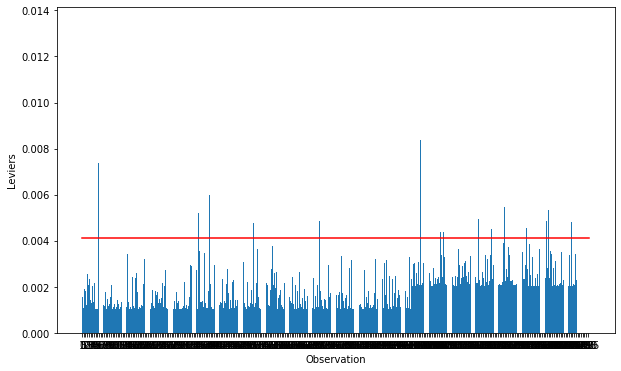

In [113]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()
hide_toggle()

In [114]:
obs_lev = analyses.loc[analyses['levier'] > seuil_levier, :]
print(obs_lev.head(),"\n")
print(len(obs_lev)," observations supérieures aux seuils")

     obs    levier
4      5  0.004748
48    49  0.007353
52    53  0.010647
54    55  0.004408
123  124  0.005865 

67  observations supérieures aux seuils


#### Calcul des résidus studentisés (Atypicité de la variable à expliquer)

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [115]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

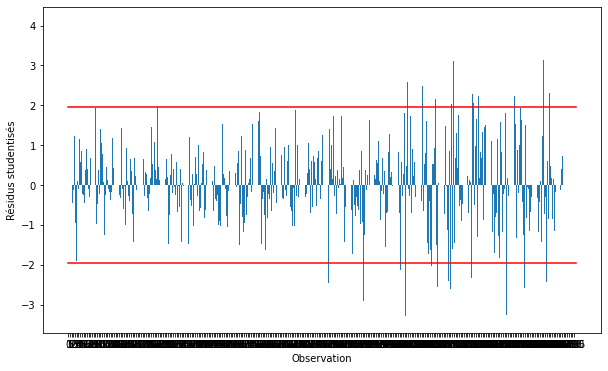

In [116]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()
hide_toggle()

In [117]:
obs_rstu = analyses.loc[(analyses['rstudent'] > seuil_rstudent) & (analyses['rstudent'] > -seuil_rstudent)]
print(obs_rstu.head(),"\n")
print(len(obs_rstu)," observations supérieures aux seuils")

       obs    levier  rstudent
263    264  0.001906  1.965931
684    685  0.001109  1.971901
994    995  0.003095  2.514038
998    999  0.002137  3.574963
1000  1001  0.008380  2.227615 

36  observations supérieures aux seuils


#### Calcul de la distance de Cook


In [118]:
influence = reg_multi.get_influence().summary_frame()

In [119]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 3/(n-p)

#### Test de la colinéarité des variables

In [120]:
# Instanciation:
reg_li_col = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", 
                   data = data)
# Calculs:
res_li_col = reg_li_col.fit()

variables = res_li_col.model.exog


for VIF in [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]:
    if VIF <= 10:
        print("VIF > 10 : Pas de problème de colinéarité")
hide_toggle()

VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité
VIF > 10 : Pas de problème de colinéarité


#### Test de l’homoscédasticité des résidus

In [121]:
_, pval, __, f_pval = sms.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval,"\n")
if pval < 5/100:
    print("pvalue < 5% ,  H0 est rejetée : les variances ne sont pas constantes(homoscédastiques).")
else : print("pvalue > 5%, H0 ne peut être rejetée : les variances sont constantes")
hide_toggle()

p value test Breusch Pagan: 3.707483368010527e-33 

pvalue < 5% ,  H0 est rejetée : les variances ne sont pas constantes(homoscédastiques).


#### Test de normalié des résidus

In [122]:
shapiro_test(pd.DataFrame(reg_multi.resid, columns =["Résidus"])["Résidus"])
hide_toggle()


					 TEST DE LA NORMALITE (TEST DE SHAPIRO) 



    	##### 0. Hypothèse du test #####

    H0 : Résidus suit une loi normale 

    H1 : Résidus ne suit pas une loi normale 

    	##### 1. Paramètre du test de Shapiro #####

    Variable aléatoire étudiée : Résidus

    Indice de confiance : 0.05

    Taille de l'échantillon : 1463

    	 #### 2. Résultat du test ####

    p-value de shapiro : 6.20942773821298e-06

    coefficient de shapiro : 0.9936248064041138
 
    	 #### 3. Conclusion du test ####

L'hypothèse nulle est rejetée 	 ==> Résidus ne suit pas une loi normale




<div class ="alert-info"> <b>Les hypothèses du modèle linéaire ne sont pas respectées. En effet, les résidus ne sont ni gaussiens, ni homoscedastiques... Mais vu la taille plus que suffisante de notre échantillon (1500 individus), les résultats du modèle seront quand même viables.</b></div>

#### Prédiction des données manquantes

In [123]:
predict_na = reg_multi.predict(df_na)

### 1.2.2. Recherche d'autres modèles avec un meilleur r2

In [124]:
# Choix du model de reression
y = df["margin_low"]
X = df[["margin_up", "is_genuine"]]

#Splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressors = [LinearRegression(), Ridge(), Lasso(), SGDRegressor()]

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", metrics.explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", metrics.mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", metrics.r2_score(y_test, y_pred))
    print()

hide_toggle()

LinearRegression()
	Training time: 0.002s
	Prediction time: 0.002s
	Explained variance: 0.6743376377018512
	Mean absolute error: 0.2897307135185014
	R2 score: 0.6736214684077528

Ridge()
	Training time: 0.002s
	Prediction time: 0.002s
	Explained variance: 0.6740590331721421
	Mean absolute error: 0.2896463361813899
	R2 score: 0.673344879445678

Lasso()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.0
	Mean absolute error: 0.5212680493567866
	R2 score: -8.248054288073625e-05

SGDRegressor()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.4600285933548508
	Mean absolute error: 0.37206643862813743
	R2 score: 0.44661960867374195



### 1.2.3. Ridge (Sklearn)

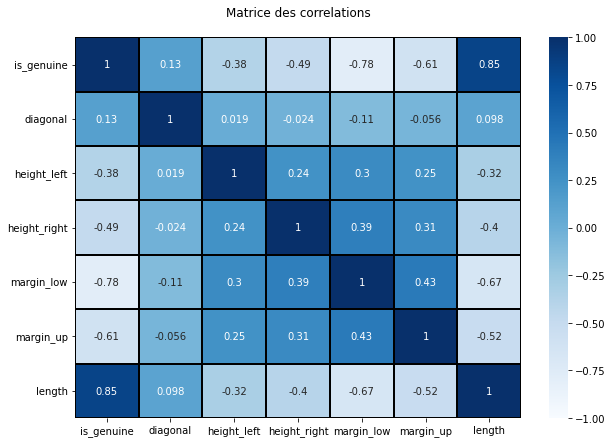

In [125]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True,linecolor='k', linewidths=2, cmap = "Blues")
plt.title("Matrice des correlations\n")
plt.show()
hide_toggle()

<div  class="alert-info">  
  <b> Corrélations observées sur la variable à prédire : </b>
    <ul><li> <b>margin up</b> : corrélation positive avec  <b>r = 0.43</b></li>
        <li> <b>is_geuine</b> : forte corrélation négative avec  <b>r =  -0.78</b></li>
        <li> <b></b><b>r inférieur à 0.4 </b>pour le reste</li>
  
</div>

In [126]:
pipeline = Pipeline([('scaler', StandardScaler()),("estimator", Ridge())])
params = {'estimator__alpha':[1, 10]}

# define the grid search
model_ridge = GridSearchCV(pipeline, param_grid=params,cv=5)
model_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', Ridge())]),
             param_grid={'estimator__alpha': [1, 10]})

In [127]:
model_ridge_opti = model_ridge.best_estimator_
model_ridge_opti.score(X_test, y_test)

0.6735714281132827

In [128]:
predict_na2 = model_ridge_opti.predict(df_na[["margin_up", "is_genuine"]])

### 1.2.4. Comparaisons des prédictions

In [180]:
df_na["predict_linear"] = predict_na
df_na["predict_ridge"] = predict_na2

C:\Users\ali75\AppData\Local\Temp\ipykernel_21448\423527462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na["predict_linear"] = predict_na
C:\Users\ali75\AppData\Local\Temp\ipykernel_21448\423527462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na["predict_ridge"] = predict_na2


In [130]:
df_na.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,predict_linear,predict_ridge
72,1,171.94,103.89,103.45,NaN,3.25,112.79,4.074248,4.075496
99,1,171.93,104.07,104.18,NaN,3.14,113.08,4.097561,4.097418
151,1,172.07,103.80,104.38,NaN,3.02,112.93,4.122994,4.121334
197,1,171.45,103.66,103.80,NaN,3.62,113.27,3.995830,4.001758
241,1,171.83,104.14,104.06,NaN,3.02,112.36,4.122994,4.121334
251,1,171.80,103.26,102.82,NaN,2.95,113.22,4.137830,4.135284
284,1,171.92,103.83,103.76,NaN,3.23,113.29,4.078487,4.079482
334,1,171.85,103.70,103.96,NaN,3.00,113.36,4.127233,4.125319
410,1,172.56,103.72,103.51,NaN,3.12,112.95,4.101800,4.101404
413,1,172.30,103.66,103.50,NaN,3.16,112.95,4.093322,4.093433


### 1.2.5. Imputation des données manquantes dans le jeu de données principal

In [131]:
data["margin_low"][data["margin_low"].isnull()] = predict_na2

C:\Users\ali75\AppData\Local\Temp\ipykernel_21448\2275961901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["margin_low"][data["margin_low"].isnull()] = predict_na2


In [132]:
data.info()

hide_toggle()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## <a name="C3">1.3. Analyse univariée</a> 

In [133]:
features = data[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]
target = data[['is_genuine']]

### <a name="C1">1.3.1. Analyse des features</a> 

Variable  diagonal  



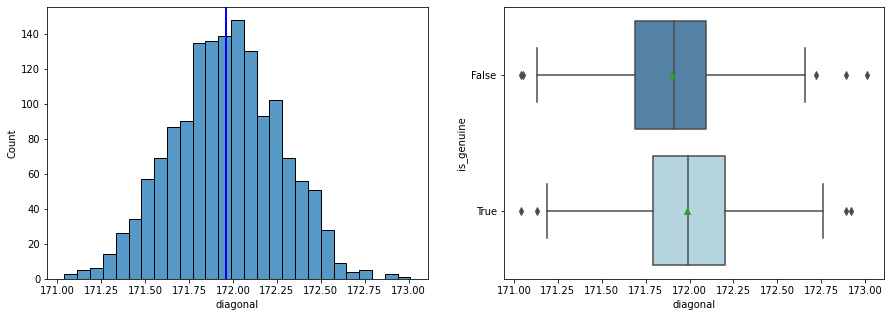

 Moyenne :  171.96
 Médiane :  171.96
 Kurtosis :  -0.13
 Écart-type :  -0.13

 ************************************************** 

Variable  height_left  



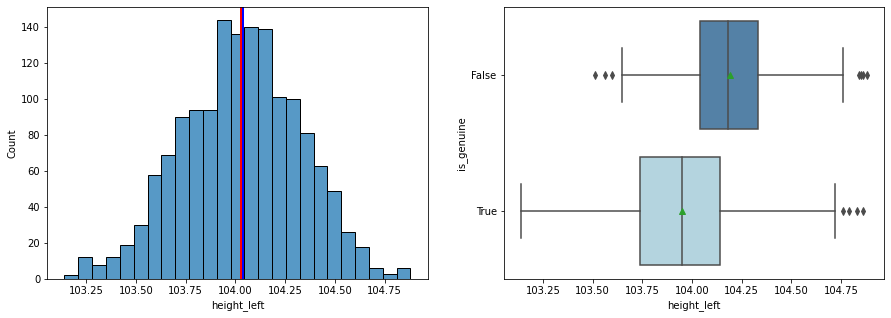

 Moyenne :  104.03
 Médiane :  104.04
 Kurtosis :  -0.2
 Écart-type :  -0.2

 ************************************************** 

Variable  height_right  



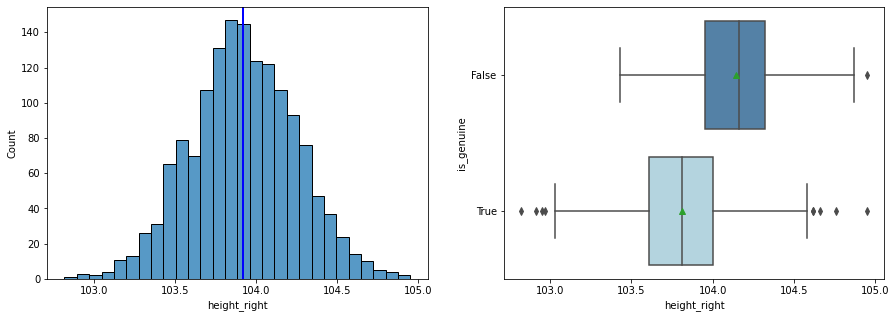

 Moyenne :  103.92
 Médiane :  103.92
 Kurtosis :  -0.03
 Écart-type :  -0.03

 ************************************************** 

Variable  margin_low  



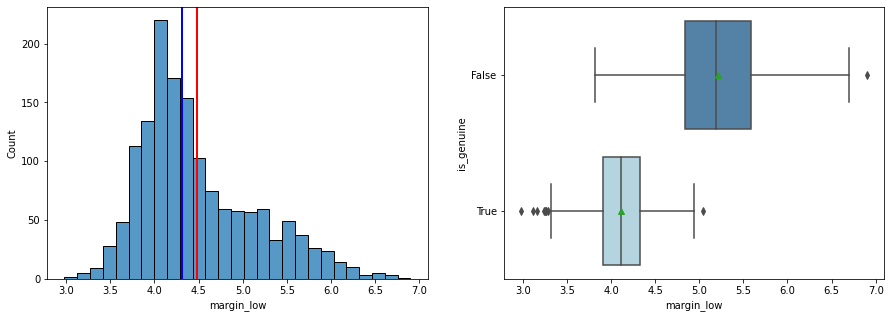

 Moyenne :  4.48
 Médiane :  4.31
 Kurtosis :  0.25
 Écart-type :  0.25

 ************************************************** 

Variable  margin_up  



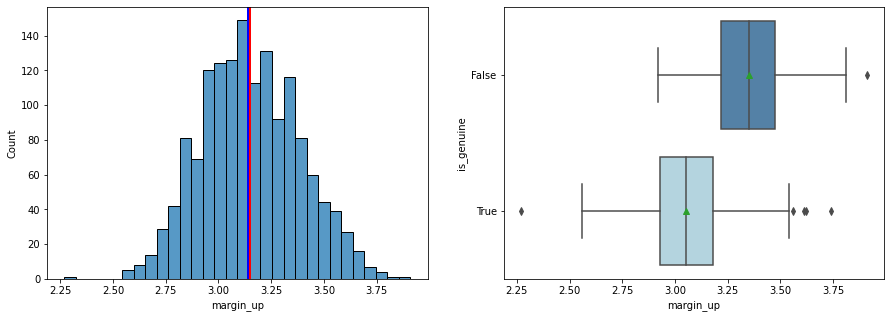

 Moyenne :  3.15
 Médiane :  3.14
 Kurtosis :  -0.25
 Écart-type :  -0.25

 ************************************************** 

Variable  length  



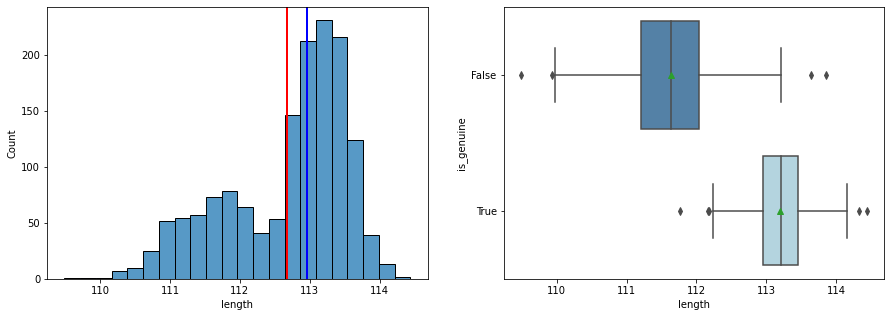

 Moyenne :  112.68
 Médiane :  112.96
 Kurtosis :  -0.28
 Écart-type :  -0.28

 ************************************************** 



In [179]:
features_names = ['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']
target_name = 'is_genuine'
palette =["steelblue","lightblue",]
for var in features_names:
    print("Variable",'\033[1m' , var,'\033[0m',"\n")
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.histplot(data = data, x=var, palette = palette);
    plt.axvline(data[var].mean(), color='r', linewidth=2)
    plt.axvline(data[var].median(), color='b', linewidth=2)
    plt.subplot(122)
    sns.boxplot(data=data, y=target_name, x=var, orient='h', showmeans=True,showfliers=True, palette=palette)
    plt.show()
    print ('\033[1m',"Moyenne :",'\033[0m', round(data[var].mean(), 2))
    print ('\033[1m',"Médiane :",'\033[0m', round(data[var].median(), 2))
    print ('\033[1m',"Kurtosis :",'\033[0m', round(data[var].kurtosis(), 2))
    print ('\033[1m',"Écart-type :",'\033[0m', round(data[var].kurtosis(), 2))
    print("\n","*"*50,"\n")

hide_toggle()

### <a name="C1">1.3.2. Analyse de la target</a> 

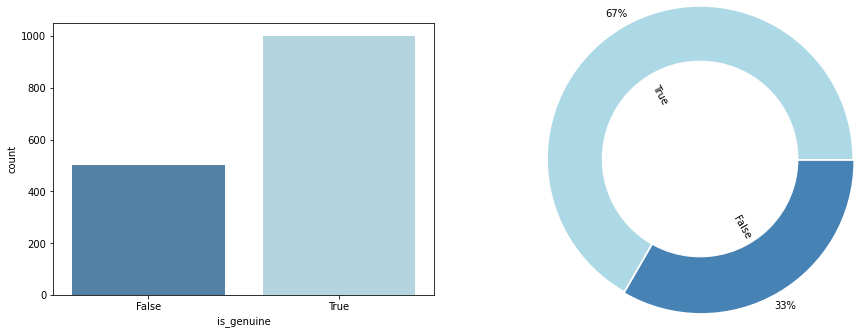

In [135]:
palette =["steelblue","lightblue",]
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x="is_genuine", data=data, palette =palette)
plt.subplot(122)
data["is_genuine"].value_counts().plot(kind="pie", ylabel='', autopct='%1.0f%%', radius=1.4, explode = (0, 0.02), 
                                       colors=["lightblue","steelblue"], pctdistance=1.1, labeldistance=0.4, rotatelabels=True)
circle = plt.Circle( (0,0), 0.9, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

plt.show()

hide_toggle()

In [137]:
data_spark.groupby("is_genuine").mean().show()

+----------+-------------+------------------+------------------+------------------+------------------+------------------+
|is_genuine|avg(diagonal)|  avg(height_left)| avg(height_right)|   avg(margin_low)|    avg(margin_up)|       avg(length)|
+----------+-------------+------------------+------------------+------------------+------------------+------------------+
|      true|    171.98708|103.94912999999993|103.80864999999989|4.1160968074150315|3.0521299999999965|113.20243000000004|
|     false|    171.90116|104.19034000000016|104.14362000000021| 5.215934959349597|3.3501599999999963|111.63064000000008|
+----------+-------------+------------------+------------------+------------------+------------------+------------------+



**Portrait-robot du vrai billet**
- Diagonale : 171.98 mm.
- Hauteur mesurée à gauche : 103.94 mm.
- Hauteur mesurée à droite : 103.80 mm.
- Marge entre le bord supérieur et le bord de l'image : 4.11 mm.
- Marge entre le bord inférieur et le bord de l'image : 3.05mm.
- Longueur : 113.20 mm.

**Portrait-robot du faux billet**
- Diagonale : 171.90 mm.
- Hauteur mesurée à gauche : 104.19 mm.
- Hauteur mesurée à droite : 104.14 mm.
- Marge entre le bord supérieur et le bord de l'image : 5.21 mm.
- Marge entre le bord inférieur et le bord de l'image : 3.35mm.
- Longueur : 111.63 mm.


In [138]:
# On exporte le df final
data.to_csv("./data/df_final.csv", encoding='utf-8', index=False)

<center><h2 >2. Clustering</h2></center>

In [139]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### <a name="C4"> 2.1. Analyse en composanates principales </a>

In [143]:
X = features

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

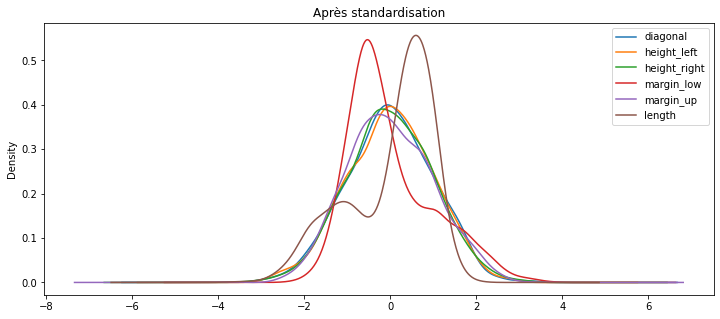

In [145]:
# After standardisation
pd.DataFrame(X_scaled,columns=X.columns).plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.title("Après standardisation")
plt.show()

hide_toggle()

In [146]:
# Create the PCA model
model_pca = PCA(n_components=6)

# Fit the model with the standardised data
X_reduced = model_pca.fit_transform(X_scaled)

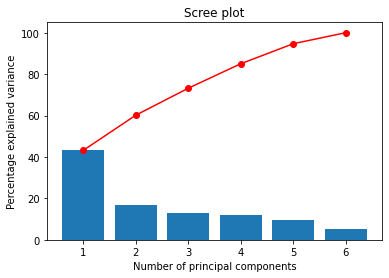

Variance expliquée cumulée : [0.43 0.6  0.73 0.85 0.95 1.  ]


In [147]:
# Scree plot
display_scree_plot(model_pca)

# Explained variance ratio cumsum
print('\033[1m' +"Variance expliquée cumulée :"+'\033[0m', model_pca.explained_variance_ratio_.cumsum().round(2))

# Nombre de composantes à étudier
num_components = 6
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]
pc3 = model_pca.components_[2]
pc4 = model_pca.components_[3]
pc5 = model_pca.components_[4]
pc6 = model_pca.components_[5]


classed_data = data.copy()
rank_band = [classed_data.loc[note_id, "is_genuine"] for note_id in classed_data.index]
X_projected = model_pca.transform(X_scaled)

hide_toggle()

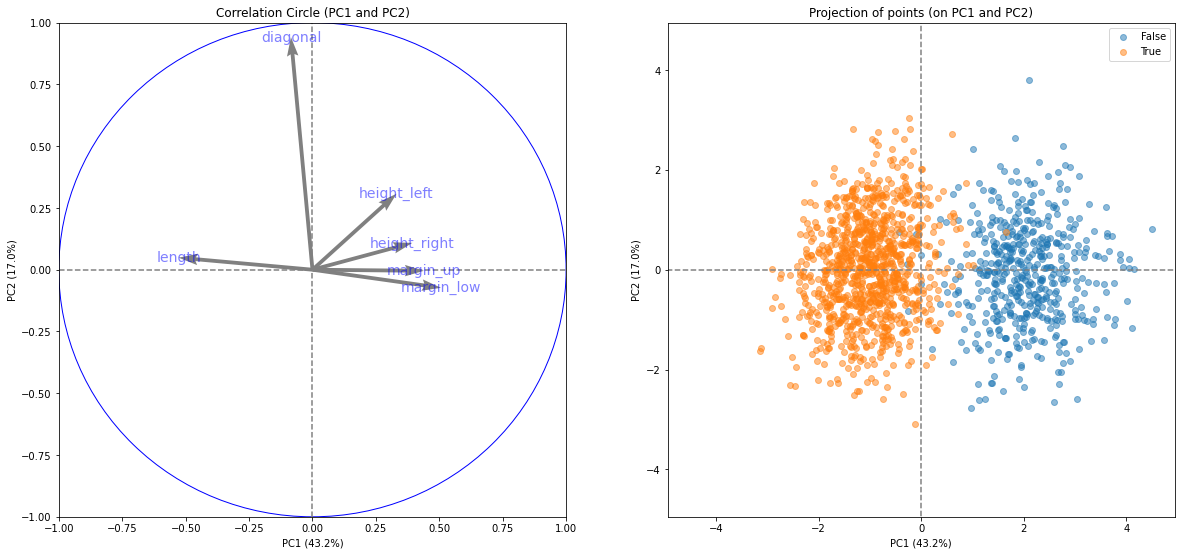

In [148]:
# Cercle des corrélations vs Plan factoriel
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)], illustrative_var = rank_band, alpha = 0.5)
plt.show()
hide_toggle()

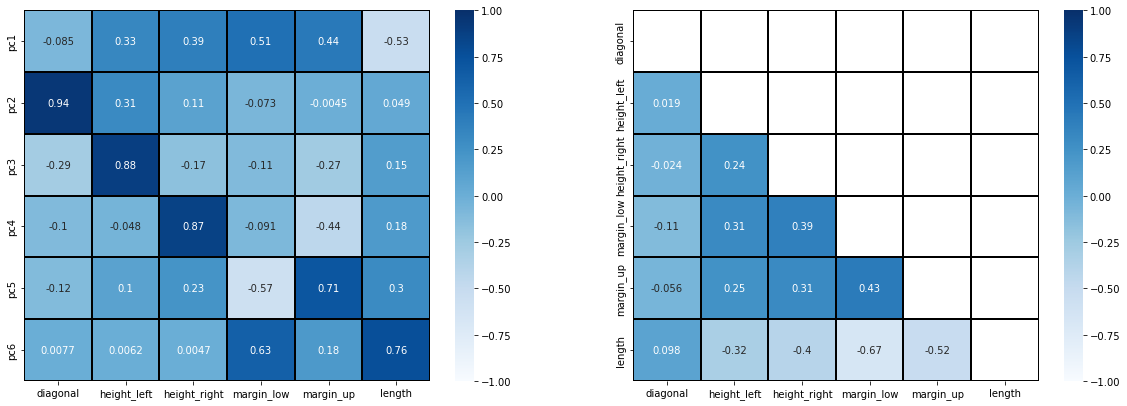

In [149]:

# Matrcices des corrélations
pcs2 = pd.DataFrame(pcs, columns=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length'],)
pcs2.index = ["pc1","pc2","pc3", "pc4", "pc5", "pc6"]

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
sns.heatmap(pcs2, annot=True,linecolor='k', linewidths=2,vmin=-1, vmax=1, cmap="Blues")
plt.subplot(2,2,2)
mask = np.triu(np.ones_like(X.corr(), dtype=bool))
sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, annot=True,linecolor='k', linewidths=2, cmap="Blues")
plt.show()
hide_toggle()

<div class="alert-info">
    <p><b>PC1 : </b>Corrélations positives entre 'height_left', 'height_right', 'margin_low', 'margin_up' et PC1 face à une corrélation négative avec length. Légère contribution négative de diagonal sur PC1</p>
<p><b>PC2 : </b> Forte corrélation positive entre PC2 et diagonal. Légères contributions positives de height_left, height_right et length. Légères contributions négatives de 'margin_low', 'margin_up' </p>
    <p><b>De manière générale, les vrais billets auront une length plus élévée alorsque les variables height_left, height_right, margin_low et margin_up seront plus élévées au niveau des faux billets.</b></p>
</div>

### <a name="C5">2.2. Recherche du nombre optimal de cluster </a>

#### 2.2.1. Elbow method

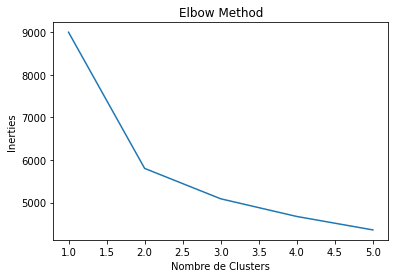

In [150]:
#Using the elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
mapping1 = {}
for i in range(1,6):
    km=KMeans(n_clusters=i)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    mapping1[i] = km.inertia_
plt.plot(range(1,6),wcss)
plt.title('Elbow Method')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inerties')
plt.show()
hide_toggle()


<div class="alert-info">
    <p><strong> Selon la méthode elbow, le nombre optimal de cluster est 2 </strong></p>
</div>
<br>

#### 2.2.2. Silhouette Score

In [151]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = list (range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
hide_toggle()

For n_clusters = 2, silhouette score is 0.34345323385360266)
For n_clusters = 3, silhouette score is 0.21100718307376048)
For n_clusters = 4, silhouette score is 0.19647487510377243)
For n_clusters = 5, silhouette score is 0.156466773283129)
For n_clusters = 6, silhouette score is 0.1494558366462989)
For n_clusters = 7, silhouette score is 0.14458263432936402)
For n_clusters = 8, silhouette score is 0.1455972978611537)
For n_clusters = 9, silhouette score is 0.1389266651546348)



<div class="alert-info">
    <p><strong> Le score de silhouhette confirme le nombre optimal de cluster égale à 2 </strong></p>
</div>
<br>

### <a name="C6">2.3. Kmeans </a>

In [152]:
model_kmeans = KMeans(n_clusters=2,random_state = 0)
model_kmeans.fit_predict(X_scaled)

array([1, 0, 0, ..., 1, 1, 1])

In [154]:
clusters =  model_kmeans.labels_

# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] =   clusters
X_clustered.head()

centres_reduced = model_pca.transform(model_kmeans.cluster_centers_)

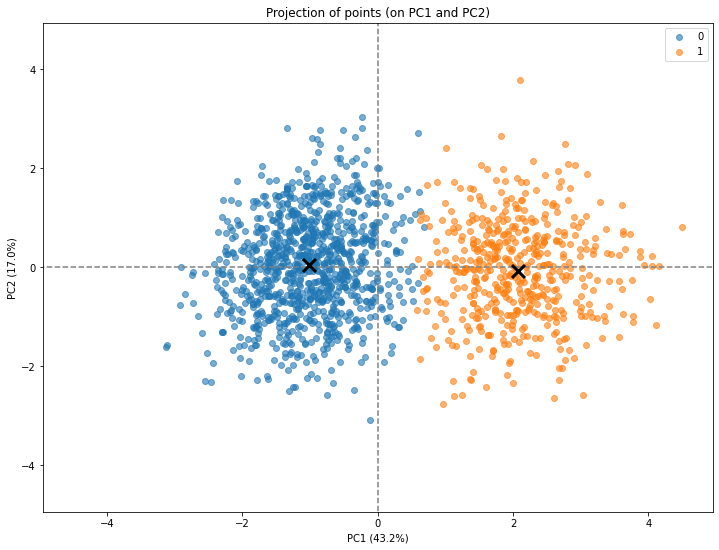

In [155]:
# Projection sur le premier plan factoriel
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters, alpha = 0.6)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1], marker='x', s=169, linewidths=3,color='black', zorder=10)
plt.show()
hide_toggle()

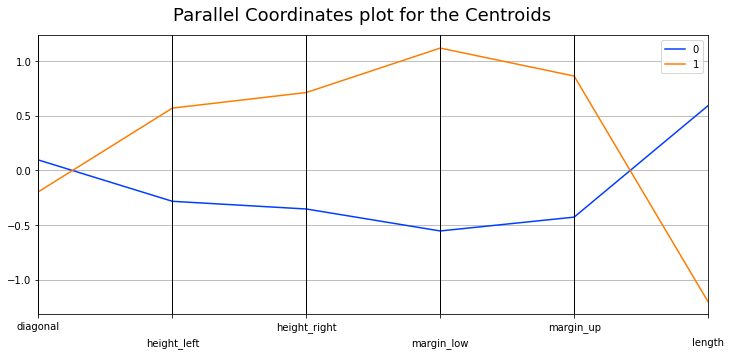

In [156]:
# Visualisation des centroïdes en coordonnées parallèles
kmeans_ =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(kmeans_.reset_index(), 5)
hide_toggle()

<div class="alert-info">
    <p><b>Cluster 0 : </b>vrais billets </p>
    <p><b>Cluster 1 : </b> faux billets </p>
    <p><b>Deux dimensions géométriques sont plus élévées sur le cluster 0</b> qui est le groupe des vrais billets. Il s'agit de :</p>
    <ul><li><b>length</b> qui est la longueur du billet (en mm) </li> 
        <li><b> et diagonal </b> qui représente la diagonale du billet (en mm) </li></ul>
    <p><b>Les 4 autres mésures sont quant à elles plus élévées sur le cluster1 </b> qui est celui des faux billets. Ce sont : </p>
    <ul><li><b>height_left </b>: la hauteur du billet (mesurée sur le côté gauche, enmm) </li>
        <li><b>height_right</b> : la hauteur du billet (mesurée sur le côté droit, en mm) </li>
        <li><b>margin_up</b> : la marge entre le bord supérieur du billet et l'image decelui-ci (en mm) </li>
        <li><b>margin_low </b>: la marge entre le bord inférieur du billet et l'image decelui-ci (en mm) </li> </ul>
</div>

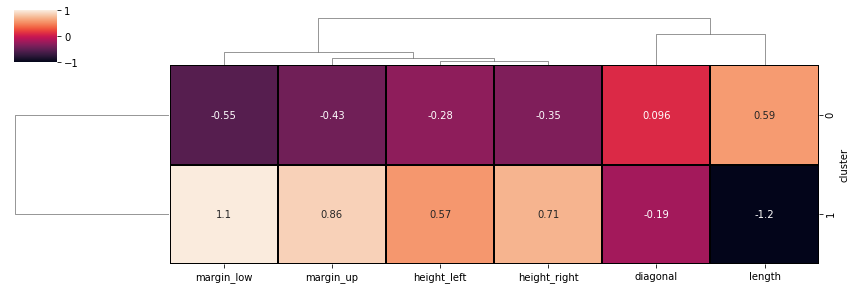

In [157]:
# Composition des groupes
sns.clustermap(kmeans_, annot=True,linecolor='k', linewidths=2,vmin=-1, vmax=1,figsize=(12,4))
plt.show()

hide_toggle()

### <a name="C8">2.4. Évaluation du modèle kmeans</a>

In [158]:
encoder = LabelEncoder()

def converter(cluster):
    if cluster==True:
        return 1
    else:
        return 0
    
data_kmeans = data.copy()   
data_kmeans['cluster_origin'] = encoder.fit_transform(np.invert(data_kmeans["is_genuine"]))
data_kmeans['cluster_kmeans'] = model_kmeans.labels_

display(data_kmeans.head())
hide_toggle()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_origin,cluster_kmeans
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0,0
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0,0
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0,0
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0,0


In [159]:
print(metrics.classification_report(data_kmeans['cluster_origin'],data_kmeans['cluster_kmeans']))
hide_toggle()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.97      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



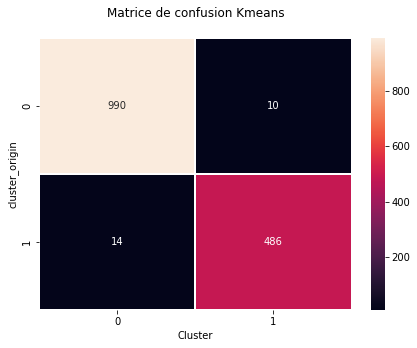

In [160]:
conf_matrix = pd.crosstab(data_kmeans['cluster_origin'], model_kmeans.labels_)
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("Cluster")
plt.title("Matrice de confusion Kmeans\n")
plt.show()
hide_toggle()

<div class="alert-info">
    <p><b> Sur 1000 billets de la classe 0: </b> nous avons <b>990 bien classés</b> contre <b> 10 mal classés</b>. </p>
    <p><b> Sur 500 billets de la classe 1: </b> nous avons <b>486 bien classés</b> contre <b> 14 mal classés</b>. </p> 
    <p><b>Taux de précision</b> pour la prédiction des <b>vrais billets</b> : <b>99% </b></p>
    <p><b>Taux de précision</b> pour la prédiction des <b>faux billets</b> : <b>98% </b></p>
        </div>

<center><h2> 3. Régression logistique </center></h2> 

### <a name="C7">3.1. Implémentation</a>

In [161]:
data_reg_log = data.copy()
data_reg_log["is_genuine"] = encoder.fit_transform(data_reg_log["is_genuine"])
# Définir notre variable dépendante y et nos varaibles indépendantes X
X = data_reg_log.iloc[:, 1:]
y = data_reg_log.iloc[:, 0]
print("Aperçu des features")
display(X.head())
hide_toggle()

Aperçu des features


,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [162]:
# Création des sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Pipeline 
model = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

In [163]:
#Prédictions
y_pred_test = model.predict(X_test)

### <a name="C8">3.2. Évaluation</a>

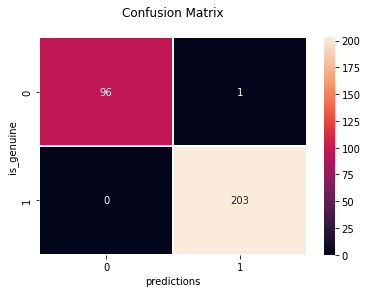

In [164]:
plt.figure(figsize=(6,4))
conf_matrix_reglog = pd.crosstab( y_test, y_pred_test)
sns.heatmap(conf_matrix_reglog, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("predictions")
plt.title("Confusion Matrix\n")
plt.show()

hide_toggle()

In [165]:
print("Test score :", model.score(X_test, y_test))
print("Train score :", model.score(X_train, y_train))
hide_toggle()

Test score : 0.9966666666666667
Train score : 0.9908333333333333


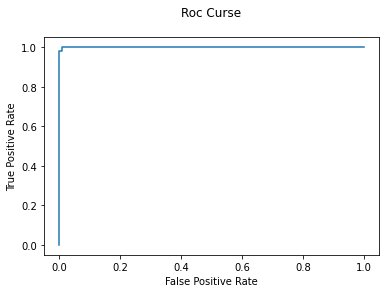

In [166]:
#ROC curve
plt.figure(figsize=(6,4))
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Roc Curse\n")
plt.subplots_adjust(wspace=0.8)
plt.show()
hide_toggle()

### <a name="C9">3.3. Optimisation </a>

#### Méthode 1

In [167]:
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'logistic__solver': ["lbfgs", "liblinear", "sag", "saga",'newton-cg',],
    'logistic__C': [50, 1.0, 0.1, 0.01]}

model_opti = GridSearchCV(model, param_grid=params, cv=cross_validation )
model_opti.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic', LogisticRegression())]),
             param_grid={'logistic__C': [50, 1.0, 0.1, 0.01],
                         'logistic__solver': ['lbfgs', 'liblinear', 'sag',
                                              'saga', 'newton-cg']})

#### Évaluation

In [168]:
model_opti = model_opti.best_estimator_
#Predictions
y_pred_test1 = model_opti.predict(X_test)

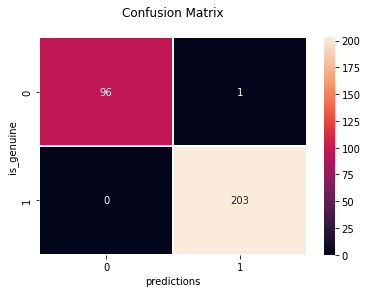

In [169]:
# Confusion matrix
conf_matrix_reglog = pd.crosstab( y_test, y_pred_test1)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_reglog, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("predictions")
plt.title("Confusion Matrix\n")
plt.show()

hide_toggle()

In [170]:
print("Test score :", model_opti.score(X_test, y_test))
print("Train score :", model_opti.score(X_train, y_train))
hide_toggle()

Test score : 0.9966666666666667
Train score : 0.99


#### Méthode 2

In [171]:
cross_validation = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
accu_stratified = []
accuracy = pd.Series(dtype=float)
iteration = 0

for train_index, test_index in cross_validation.split(X, y):
    
    iteration += 1 # short version of "iteration = iteration + 1"
        
    # Dataset d'entrainement
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    # dataset de Test
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
# Pipeline 
model_opti2 = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])
model_opti2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

#### Évaluation

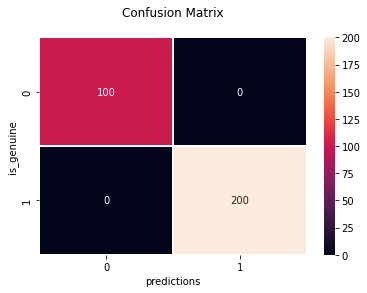

In [172]:
y_pred_test2 = model.predict(X_test)
# Confusion matrix
conf_matrix_reglog = pd.crosstab( y_test, y_pred_test2)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_reglog, annot = True, fmt = ".3g", linewidths = 0.3)
plt.xlabel("predictions")
plt.title("Confusion Matrix\n")
plt.show()
hide_toggle()

In [173]:
print("Test score :", model_opti2.score(X_test, y_test))
print("Train score :", model_opti2.score(X_train, y_train))
hide_toggle()

Test score : 1.0
Train score : 0.99


<center><h2> 4. Test des modèles </h2></center>  

### <a name="C10"> 4.1. Préparation de l'échatillon</a>

In [174]:
# Fichier à tester
billets_prod = pd.read_csv("./data/billets_production.csv")
print("Aperçu du fichier à tester")
display(billets_prod.head())
hide_toggle()

Aperçu du fichier à tester


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


### <a name="C11"> 4.2. Implémentation de la fonction test</a>

<b>On prépare la fonction contenant les modèles kmeans et regression logistique pour le test ...</b>

In [175]:
def fake_detect(data, model ="logistic"):
    X = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]
    
    if model == "logistic":
        predictions = model_opti2.predict(X)
        probas = model_opti2.predict_proba(X)
        X['Probas_faux'] = probas[:,0]
        X['Probas_vrais'] = probas[:,1]
        X["Predictions"] = predictions
        X["Nature_billet"] = X["Predictions"].copy()
        X["Nature_billet"].replace([0,1],["Faux billet", "Vrai billet"], inplace=True)
        
    elif model == "kmeans":
        X = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]
        scaler = StandardScaler()
        X2 = scaler.fit_transform(X)
        clusters =  model_kmeans.predict(X2)
        X["Predictions"] = clusters
        X["Nature_billet"] = X["Predictions"].copy()
        X["Nature_billet"].replace([0,1],["Vrai billet", "Faux billet"], inplace=True)
        
    print(" "*50,"*"*50,"\n")
    print('\033[1m' + "Nombre total de billets : " +  '\033[0m',len(X))
    print('\033[1m' + "Nombre de billets authentiques : " +  '\033[0m',len(X[X["Predictions"]== 1]))
    print('\033[1m' + "Nombre de faux billets : " +  '\033[0m',len(X[X["Predictions"]== 0]), "\n")
 
    labels=["Faux billet", "Vrai billet"]
    sns.countplot(x="Nature_billet", data=X, palette=["darkslategrey","bisque"])
    plt.show()
    print(" "*50,"*"*50,"\n")


### <a name="C12"> 4.3. Résultats des tests</a>

#### 4.3.1. Regression logistic

                                                   ************************************************** 

Nombre total de billets :  5
Nombre de billets authentiques :  2
Nombre de faux billets :  3 



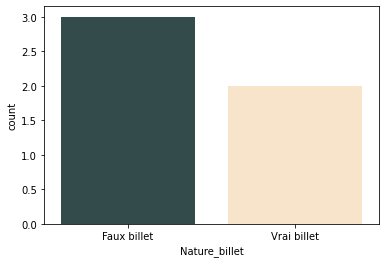

                                                   ************************************************** 



In [176]:
fake_detect(billets_prod, model = "logistic")

#### 4.3.2. KMeans

                                                   ************************************************** 

Nombre total de billets :  5
Nombre de billets authentiques :  3
Nombre de faux billets :  2 



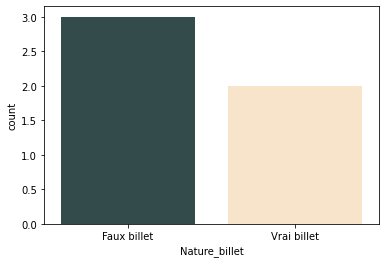

                                                   ************************************************** 



In [177]:
fake_detect(billets_prod, model = "kmeans")

<center><h2> 5. Streamlit App</h2></center>

L'application a été développée sur vscode, elle a ensuite été deployée sur github puis share.streamlit

Github repository : https://github.com/Alhasdata/FakeNotes_Dectector

Streamlit share : https://alhasdata-fakenotes-dectector-main-ff5ra5.streamlitapp.com/

In [ ]:
import session_info
session_info.show()